# Improving model performance with xfeat, RAPIDS and Optuna


## Introduction

Feature Engineering is the processing of transforming raw data into features that can represent the underlying patterns of the data better. They can help boost accuracy by a great deal and improve the ability of the model to generalise on unseen data. Every data scientist knows the importance of feature engineering. Spending some time thinking about how best to apply and combine the available features can be very meaningful.

Hyper parameter Optimisation is another such process which can help complement a good model by tuning it's hyperparameters, which can have a tremendous impact on the accuracy of the model. 

The time and resources required for these processes are generally the reason they're overlooked. With xfeat, RAPIDS and Optuna - we aim to bridge these gaps and elevate the performance.


## What is Optuna?
[Optuna](https://github.com/optuna/optuna) is a lightweight framework for automatic hyperparameter optimization. It provides a define-by-run API, which makes it easy to adapt to any already existing code that we have and enables high modularity and the flexibility to construct hyperparameter spaces dynamically. By simply wrapping the objective function with Optuna can help perform a parallel-distributed HPO search over a search space. As we'll see in this notebook.


## What is xfeat?
[xfeat](https://github.com/pfnet-research/xfeat) is a feature engineering & exploration library using GPUs and Optuna. It provides a scikit-learn-like API for feature engineering with support for Pandas, cuDF data frames and cuPy arrays.

## What is RAPIDS?
[RAPIDS](https://rapids.ai/about.html) framework provides a library suite that can execute end-to-end data science pipelines entirely on GPUs. The libraries in the framework include [cuDF](https://github.com/rapidsai/cudf) - a GPU Dataframe with pandas-like API, [cuML](https://github.com/rapidsai/cuml) - implement machine learning algorithms that provide a scikit-learn-like API and many more. You can learn more [here](https://github.com/rapidsai).

In this notebook, we'll show how one can use these tools together to develop and improve a machine learning model. We'll use Airlines dataset (20M rows) to predict if a flight will be delayed or not. We'll explore how to use Optuna with RAPIDS and the speedups that we can achieve with the integration of these, and to see the improvements with GPU speedups, we ran the experiment on the CPU and included the table summarizing the results at the end of the notebook.

### Pre-requisites

Version requirements:
- RAPIDS libraries (cuDF, cuML) > 0.15

Run the following in a new cell to install these packages:

```
!pip install optuna
!pip install plotly
!pip install kaleido
!pip install xfeat
```

Restart the kernel after you've installed the packages and then run the notebook.

In [1]:
import time
import json
import requests
import logging

import numpy as np

import cupy
import cudf
import cuml
from cuml import LogisticRegression
from cuml.metrics import roc_auc_score
from cuml.preprocessing.model_selection import train_test_split


import optuna
from optuna.study import StudyDirection
from optuna.trial import TrialState
from optuna import type_checking

import xfeat
from xfeat.pipeline import Pipeline
from xfeat.num_encoder import SelectNumerical
from xfeat.selector import ChiSquareKBest
from xfeat.optuna_selector import KBestThresholdExplorer
from functools import partial

import sklearn
from sklearn.model_selection import KFold
import pandas as pd


from cuml.preprocessing.LabelEncoder import LabelEncoder
from cuml.preprocessing.TargetEncoder import TargetEncoder
from xfeat import ArithmeticCombinations, Pipeline, SelectNumerical

In [2]:
import time
from contextlib import contextmanager
# Helping time blocks of code
@contextmanager
def timed(txt):
    t0 = time.time()
    yield
    t1 = time.time()
    print("%32s time:  %8.5f" % (txt, t1 - t0))

# Loading the data
## Data Acquisition
We'll use the cell below to download the data. The `file_name` specifies which of the two available files we want to use. The two files are - `airline_small.parquet` (smaller file) and `airline_20000000.parquet`. By default, we use the smaller file. You are free to change it for experimentation.

Set the `download_data=True` and `data_dir` to a local path in your system to download the data into the path of `data_dir`

In [3]:
import os
download_data = True

file_name = 'airline_small.parquet' # NOTE: Change to airline_20000000.parquet to use a larger dataset

data_dir = "/home/data/airline_data/" # NOTE: Change to a local path where you want to save the file
INPUT_FILE = os.path.join(data_dir, file_name)

In [4]:
if download_data:
    from urllib.request import urlretrieve

    if os.path.isfile(INPUT_FILE):
            print(f" > File already exists. Ready to load at {INPUT_FILE}")
    else:
        # Ensure folder exists
        os.makedirs(data_dir, exist_ok=True)

    url = "https://rapidsai-cloud-ml-sample-data.s3-us-west-2.amazonaws.com/" + file_name

    urlretrieve(url= url,filename=INPUT_FILE)

    print("Completed!")

 > File already exists. Ready to load at /home/data/airline_data/airline_small.parquet
Completed!


### Feature Engineering

The following functions are defined to perform a few feature engineering tasks on the data. The `feature_engineering` function is called on the dataframe df, in this function we perform Label and Target Encoding on the categorical columns using cuML functions, and Arithmetic Combinations on the numerical columns using xfeat. The Arithmetic Operation performed here is addition on two columns at once. We specify the operator and r, which is used to indicate how many columns need to be combined.

You'll also notice we use `Pipeline` from xfeat to combine two or more feature engineering tasks together. This is useful to concatenate encoders sequentially.

Read more about Feature Encoding and Pipelining with xfeat [here](https://github.com/pfnet-research/xfeat/blob/master/_docs/feature_encoding.md).

In [5]:
def feature_engineering(df):
    """
    Perform feature engineering and return a new df with engineered features
    """
    df_train, df_test, y_train, y_test = train_test_split(df, TARGET_COL,random_state=np.random.seed(0),
                                                          shuffle=True)
 
    # Xfeat's internal fold mechanism creates RangeIndex references, so we need to do an index reset on our data frames.
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    # Need to do this to ensure we are appropriately assigning the split values
    df_train[TARGET_COL] = y_train
    df_test[TARGET_COL] = y_test
    
    
    for col in CAT_COLS:
        out_col = f'{col}_TE'
        lbl_enc = LabelEncoder(handle_unknown='ignore')
        tar_enc = TargetEncoder(n_folds=5, smooth=TARGET_ENC_SMOOTH, split_method=TARGET_ENC_SPLIT)
        
        df_train[col] = lbl_enc.fit_transform(df_train[col])
        df_train[out_col] = tar_enc.fit_transform(df_train[col], df_train[TARGET_COL])
        
        df_test[out_col] = tar_enc.transform(df_test[col])
        df_test[col] = lbl_enc.transform(df_test[col]).fillna(0)
        del lbl_enc, tar_enc



    encoder = Pipeline([
                        SelectNumerical(),
                        ArithmeticCombinations(exclude_cols=[TARGET_COL],
                                               drop_origin=False,
                                               operator="+",
                                               r=2,
                                               output_suffix="_plus")
                    ])

    df_train = encoder.fit_transform(df_train)
    df_test = encoder.transform(df_test)
    df = cudf.concat([df_train, df_test], sort=False)

    return df

### Feature Selection and Hyper parameter Optimisation

Now that we have some new features, how do we know they are relevant for the task or represent anything meaningful? We use the feature selection process to do this. This helps in selection of a subset of features that are most informative. This helps in simplifying the problem and ensures that we aren't overloading the system with unimportant features. 

Optuna provides a way to choose a selector which accepts a `Pipeline` object from xfeat. You can see in the `feature_selection` function we define a `Pipeline` that takes in an Explorer and a Selection Algorithm (`ChiSquareKBest`). We pass this to an Optuna Study object, along with an Objective function.
Chi squared tests are used to test the independence of two events. 

For Feature Selection, we aim to select features, which are highly dependent on the response. This way, we can get features that will best determine the outcome.

### Objective Function

The objective function will be the one we optimize in Optuna Study. Objective function tries out different values for the parameters that we are tuning and saving the results in `study.trials_dataframes()`.

Let's define the objective function for this HPO task by making use of the `train_and_eval()`. You can see that we simply choose a value for the parameters and call the train_and_eval method, making Optuna very easy to use in an existing workflow.

The objective remains constant over different samplers, which are built-in options in Optuna to enable the selection of different sampling algorithms that optuna provides. Some of the available ones include - GridSampler, RandomSampler, TPESampler, etc. We'll use TPESampler for this demo, but feel free to try different samplers to notice the changes in performance. Tree-structured Parzen Estimator or TPE is based on independent sampling. It fits a Gaussian Mixture Model for each parameter in a trial `l(x)` and another GMM `g(x)` for other parameters. And it optimizes the `l(x)/g(x)` ratio to yield the best parameters.



### HPO Trials and Study
Optuna uses [study](https://optuna.readthedocs.io/en/stable/reference/study.html) and [trials](https://optuna.readthedocs.io/en/stable/reference/trial.html) to keep track of the HPO experiments. Put simply, a trial is a single call of the objective function while a set of trials make up a study. We will pick the optimal performing trial from a study to get the best parameters that were used in that run.

In [6]:
def train_and_eval(df, penalty='l2', C=1.0, l1_ratio=None, fit_intercept=True, selector=None):
    # Splitting data and prepping for selector fit
    X_train,  X_test, y_train, y_test = train_test_split(df,
                                                         TARGET_COL,
                                                         random_state=np.random.seed(0),
                                                         shuffle=True)

    # Xfeat's internal fold mechanism creates RangeIndex references, so we need to do an index reset on our data frames.

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    if selector:
        # For the selector, the label also needs to be in the DF
        X_train[TARGET_COL] = y_train
        X_test[TARGET_COL] = y_test

        X_train = selector.fit_transform(X_train)
        X_test = selector.transform(X_test)

    # Train and get accuracy
    classifier = LogisticRegression(penalty=penalty,
                                    C=C,
                                    l1_ratio=l1_ratio,
                                    fit_intercept=fit_intercept)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict_proba(X_test.values)[:, 1]
    y_pred = y_pred.astype(y_test.dtype)
    score = roc_auc_score(y_test, y_pred)

    return score, classifier


def objective(df, selector, trial):
    """
    Performs the training and evaluation of the set of parameters and subset of features using selector.
    """
    selector.set_trial(trial)
    
    # Select Params
    C = trial.suggest_uniform("C", 0 , 7.0)
    penalty = trial.suggest_categorical("penalty", ['l1', 'none', 'l2'])
    l1_ratio = trial.suggest_uniform("l1_ratio", 0 , 1.0)
    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
    
    score, _ = train_and_eval(df,
                           penalty=penalty,
                           C=C,
                           l1_ratio=l1_ratio,
                           fit_intercept=fit_intercept,
                           selector=selector)
    return score

def feature_selection(df, experiment_name):
    """
    Defines the Pipeline and performs the optuna opt
    """
    selector = Pipeline(
        [
            SelectNumerical(),
            KBestThresholdExplorer(ChiSquareKBest(target_col=TARGET_COL)),
        ]
    )


    study = optuna.create_study(direction="maximize")

    study.optimize(partial(objective, df, selector), n_trials=N_TRIALS)

    selector.from_trial(study.best_trial)
    selected_cols = selector.get_selected_cols()

    df_select = df[selected_cols]
    df_select[TARGET_COL] = df[TARGET_COL]

    params = study.best_params
    score, classifier = train_and_eval(df_select,
                  C=params['C'],
                  penalty=params['penalty'],
                  l1_ratio=params['l1_ratio'],
                  fit_intercept=params['fit_intercept'])

    return study, df_select.reset_index(drop=True), classifier, score

### Set Experiment Variables

Change the `INPUT_FILE` to correspond to the path in your local system and select the number of rows and trials to run the experiment for. 

In [7]:
N_ROWS = 10000000
N_TRIALS = 50

TARGET_ENC_SMOOTH = 0.001
TARGET_ENC_SPLIT = 'interleaved'

CAT_COLS = ["Dest", "Origin", "UniqueCarrier"]
TARGET_COL = "ArrDelayBinary"

## GPU Run

Now, let's run the RAPIDS version by first reading in the data as cudf DataFrames.

In [8]:
import time
start_time = time.time()

In [9]:
df_ = cudf.read_parquet(INPUT_FILE)[:N_ROWS]
# Can't handle nagative values, yet
df_ = df_.drop(["ActualElapsedTime"], axis=1)
print("Default performance: ", train_and_eval(df_)[0])

df_.head()

Default performance:  0.5


,ArrDelayBinary,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,Origin,Dest,Distance,Diverted
0,1,1987.0,10.0,1.0,4.0,1.0,556.0,0.0,190.0,220.0,175.0,1846.0,0.0
1,0,1987.0,10.0,1.0,4.0,5.0,114.0,4.0,57.0,132.0,219.0,337.0,0.0
2,1,1987.0,10.0,1.0,4.0,5.0,35.0,5.0,351.0,116.0,130.0,987.0,0.0
3,0,1987.0,10.0,1.0,4.0,5.0,40.0,3.0,251.0,148.0,179.0,142.0,0.0
4,1,1987.0,10.0,1.0,4.0,8.0,517.0,12.0,500.0,131.0,175.0,1515.0,0.0


In [10]:
# We cast to objects for categorical  and target encoding
# Can't pass categorical directly to LR
for col in CAT_COLS:
    df_[col] = df_[col].astype("object")

with timed("FE"):
    df_feature_eng = feature_engineering(df_)
    df_feature_eng[TARGET_COL] = df_feature_eng[TARGET_COL].astype('float64')
    score, _ = train_and_eval(df_feature_eng)
    print("After feature eng: ", score)

df_feature_eng.head()

/opt/conda/envs/rapids/lib/python3.7/site-packages/cudf/core/join/join.py:368: UserWarning: can't safely cast column from right with type uint8 to object, upcasting to None
  "right", dtype_r, dtype_l, libcudf_join_type


After feature eng:  0.5393422842025757
                              FE time:   2.31190


,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,Origin,Dest,...,DistanceDiverted_plus,DistanceDest_TE_plus,DistanceOrigin_TE_plus,DistanceUniqueCarrier_TE_plus,DivertedDest_TE_plus,DivertedOrigin_TE_plus,DivertedUniqueCarrier_TE_plus,Dest_TEOrigin_TE_plus,Dest_TEUniqueCarrier_TE_plus,Origin_TEUniqueCarrier_TE_plus
0,1987.0,10.0,4.0,7.0,1257.0,1529.0,3,304.0,146,27,...,1005.0,1005.212733,1005.081820,1005.180651,0.212733,0.081820,0.180651,0.294553,0.393384,0.262471
1,1987.0,10.0,8.0,4.0,2005.0,2112.0,13,428.0,194,168,...,406.0,406.124254,406.152137,406.129355,0.124254,0.152137,0.129355,0.276392,0.253609,0.281492
2,1987.0,10.0,5.0,1.0,845.0,1000.0,0,2422.0,133,33,...,373.0,373.257953,373.178142,373.119750,0.257953,0.178142,0.119750,0.436095,0.377703,0.297892
3,1987.0,10.0,1.0,4.0,1054.0,1200.0,2,1822.0,122,33,...,315.0,315.258722,315.189735,315.335541,0.258722,0.189735,0.335541,0.448456,0.594262,0.525275
4,1987.0,10.0,2.0,5.0,1800.0,2046.0,5,8.0,49,93,...,773.0,773.202355,773.107499,773.211875,0.202355,0.107499,0.211875,0.309855,0.414230,0.319374


In [11]:
import random
exp_name = 'Optuna-SingleGPU' + str(random.randint(0,100))
with timed("FS + Optuna"):
    # Disable Alembic driver, used by MLflow, from logging INFO messages to the command line.
    logging.getLogger('alembic').setLevel(logging.CRITICAL)
    study, df_select, best_clf, score = feature_selection(df_feature_eng, experiment_name=exp_name)
    print("Best score after Feature Selection + Optuna: ", score)
df_select.head()

[I 2020-09-15 17:01:05,342] A new study created in memory with name: no-name-cf40b9ed-826d-4804-9935-33f012398a01
[I 2020-09-15 17:01:06,896] Trial 0 finished with value: 0.5519541501998901 and parameters: {'C': 5.964223486192339, 'penalty': 'none', 'l1_ratio': 0.9807496579513754, 'fit_intercept': True, 'KBestThresholdExplorer.k': 118.0}. Best is trial 0 with value: 0.5519541501998901.
[I 2020-09-15 17:01:08,221] Trial 1 finished with value: 0.6061785221099854 and parameters: {'C': 0.7308111219782873, 'penalty': 'l1', 'l1_ratio': 0.9604704200014856, 'fit_intercept': False, 'KBestThresholdExplorer.k': 51.0}. Best is trial 1 with value: 0.6061785221099854.
[I 2020-09-15 17:01:09,478] Trial 2 finished with value: 0.5784950256347656 and parameters: {'C': 3.1169970857083795, 'penalty': 'l2', 'l1_ratio': 0.0828025719605805, 'fit_intercept': False, 'KBestThresholdExplorer.k': 65.0}. Best is trial 1 with value: 0.6061785221099854.
[I 2020-09-15 17:01:10,867] Trial 3 finished with value: 0.5636

Best score after Feature Selection + Optuna:  0.6647772789001465
                     FS + Optuna time:  74.93254


,DayofMonth,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,Origin,Dest,Distance,Dest_TE,Origin_TE,...,DistanceDest_TE_plus,DistanceOrigin_TE_plus,DistanceUniqueCarrier_TE_plus,DivertedDest_TE_plus,DivertedOrigin_TE_plus,DivertedUniqueCarrier_TE_plus,Dest_TEOrigin_TE_plus,Dest_TEUniqueCarrier_TE_plus,Origin_TEUniqueCarrier_TE_plus,ArrDelayBinary
0,4.0,1257.0,1529.0,3,304.0,146,27,1005.0,0.212733,0.081820,...,1005.212733,1005.081820,1005.180651,0.212733,0.081820,0.180651,0.294553,0.393384,0.262471,0.0
1,8.0,2005.0,2112.0,13,428.0,194,168,406.0,0.124254,0.152137,...,406.124254,406.152137,406.129355,0.124254,0.152137,0.129355,0.276392,0.253609,0.281492,0.0
2,5.0,845.0,1000.0,0,2422.0,133,33,373.0,0.257953,0.178142,...,373.257953,373.178142,373.119750,0.257953,0.178142,0.119750,0.436095,0.377703,0.297892,0.0
3,1.0,1054.0,1200.0,2,1822.0,122,33,315.0,0.258722,0.189735,...,315.258722,315.189735,315.335541,0.258722,0.189735,0.335541,0.448456,0.594262,0.525275,0.0
4,2.0,1800.0,2046.0,5,8.0,49,93,773.0,0.202355,0.107499,...,773.202355,773.107499,773.211875,0.202355,0.107499,0.211875,0.309855,0.414230,0.319374,0.0


In [12]:
end_time = time.time()
print("Complete workflow ", end_time - start_time)

Complete workflow  80.82859301567078


In [13]:
df_feature_eng.head()

,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,Origin,Dest,...,DistanceDiverted_plus,DistanceDest_TE_plus,DistanceOrigin_TE_plus,DistanceUniqueCarrier_TE_plus,DivertedDest_TE_plus,DivertedOrigin_TE_plus,DivertedUniqueCarrier_TE_plus,Dest_TEOrigin_TE_plus,Dest_TEUniqueCarrier_TE_plus,Origin_TEUniqueCarrier_TE_plus
0,1987.0,10.0,4.0,7.0,1257.0,1529.0,3,304.0,146,27,...,1005.0,1005.212733,1005.081820,1005.180651,0.212733,0.081820,0.180651,0.294553,0.393384,0.262471
1,1987.0,10.0,8.0,4.0,2005.0,2112.0,13,428.0,194,168,...,406.0,406.124254,406.152137,406.129355,0.124254,0.152137,0.129355,0.276392,0.253609,0.281492
2,1987.0,10.0,5.0,1.0,845.0,1000.0,0,2422.0,133,33,...,373.0,373.257953,373.178142,373.119750,0.257953,0.178142,0.119750,0.436095,0.377703,0.297892
3,1987.0,10.0,1.0,4.0,1054.0,1200.0,2,1822.0,122,33,...,315.0,315.258722,315.189735,315.335541,0.258722,0.189735,0.335541,0.448456,0.594262,0.525275
4,1987.0,10.0,2.0,5.0,1800.0,2046.0,5,8.0,49,93,...,773.0,773.202355,773.107499,773.211875,0.202355,0.107499,0.211875,0.309855,0.414230,0.319374


In [14]:
print("The details of the best trial ", study.best_trial)

The details of the best trial  FrozenTrial(number=14, value=0.6713966131210327, datetime_start=datetime.datetime(2020, 9, 15, 17, 1, 24, 196562), datetime_complete=datetime.datetime(2020, 9, 15, 17, 1, 25, 750219), params={'C': 1.895018590355287, 'penalty': 'l1', 'l1_ratio': 0.5958252897235429, 'fit_intercept': False, 'KBestThresholdExplorer.k': 98.0}, distributions={'C': UniformDistribution(high=7.0, low=0), 'penalty': CategoricalDistribution(choices=('l1', 'none', 'l2')), 'l1_ratio': UniformDistribution(high=1.0, low=0), 'fit_intercept': CategoricalDistribution(choices=(True, False)), 'KBestThresholdExplorer.k': DiscreteUniformDistribution(high=120, low=1, q=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=14, state=TrialState.COMPLETE)


## Performance Summarization

We noticed that Feature Engineering alone takes 28.47 seconds on CPU vs 7.78 seconds on GPU, yielding a 4x speed up.
Performing Feature engineering and Selection boosts the AUC score from 0.61 to 0.72. By repeating this task on a larger portion of the data, a wider search space, we would be able to achieve a better improvement.
From our experiments, GPU runs are faster for 100,000 rows (and 10 trials) and we are able to obtain 5x speedups. For more performance improvements, you are encouraged to increase the number of rows and/or number of trials. This will result in a big boost in accuracy. Keep in mind, you do not want to run the experiment on the CPU with a larger number of rows, as this will result in the kernel crashing.
 
Below is a tablet summarizing the results from our experiments.


|Number of rows| Trials| CPU | GPU|
|-|-|-|-|
|100K|10|64.83|12.97|
|1M|10|-|60.14|
|10M|10|-|464.03|

## Visualization

Let's look at some graphs to understand and visualize what we achieved in this notebook. 

The graph below shows the importance of a feature for the performance. We see that the `penalty` set in Logistic Regression and `K` from the Chi-square test have the highest importance in performance.

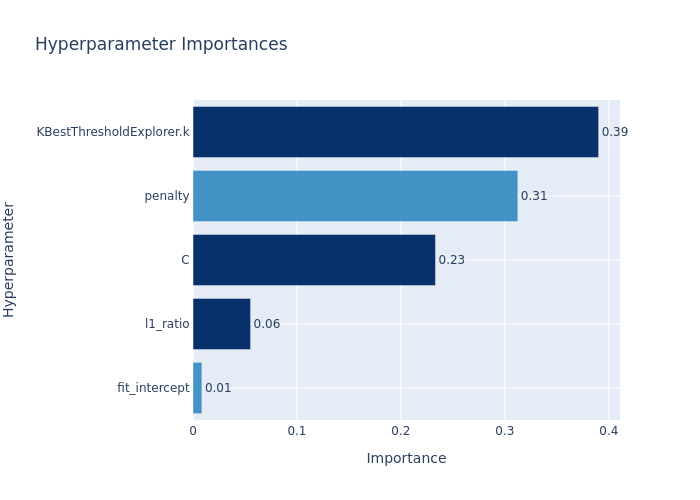

In [15]:
from IPython.display import Image

f = optuna.visualization.plot_param_importances(study)
Image(f.to_image(format="png", engine='kaleido'))

The following is a slice plot to better understand the parameter relationships. We see how the change in the parameter affects the performance of the model.

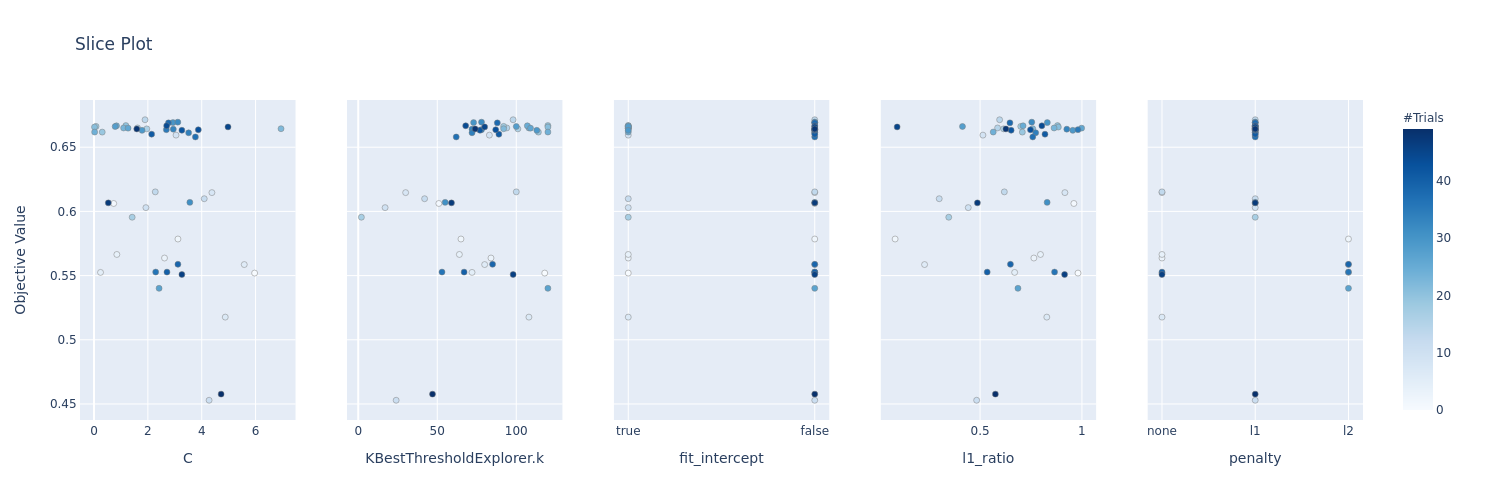

In [16]:
f = optuna.visualization.plot_slice(study, params=['l1_ratio', 'C', 'KBestThresholdExplorer.k', 'penalty', 'fit_intercept'])
Image(f.to_image(format="png", engine='kaleido'))

Let's plot the history of all trials in the study to see how the performance improvements took place within the study

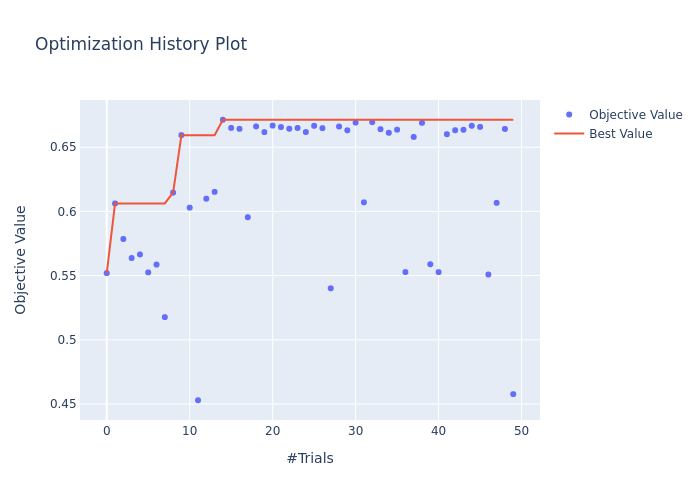

In [17]:
f = optuna.visualization.plot_optimization_history(study)
Image(f.to_image(format="png", engine='kaleido'))

## Closing Thoughts

We’ve seen how to use RAPIDS alongside xfeat and Optuna to get performance boosts in terms of run-time and AUC score. The notebook can serve as a starting point for anyone looking to get started on using GPUs to run Hyperparameter Optimization and Feature Engineering experiments. These can add value by yielding better performing models much faster than CPU runs.

## Additional Reources

Here are a few additional resources and reading for anyone interested:

[How to Win a DS Kaggle competition](https://www.coursera.org/learn/competitive-data-science)

[Target Encoding and Bayesian Target Encoding](https://towardsdatascience.com/target-encoding-and-bayesian-target-encoding-5c6a6c58ae8c)

[Learn more about using MLFlow with RAPIDS](https://github.com/mlflow/mlflow/tree/master/examples/rapids/mlflow_project)

[Algorithms for Hyper-Parameter Optimization](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)

You can find the libraries here: [RAPIDS](https://rapids.ai/), [xfeat](https://github.com/pfnet-research/xfeat/tree/master/xfeat), [Optuna](https://optuna.readthedocs.io/en/stable/)